In [33]:
%load_ext autoreload
%autoreload 2

import cv2
import json
import os
import shutil

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from tqdm import tqdm

from tools.coco_formatter import COCOFormatter
from tools.demo import Predictor
from yolox.exp import get_exp
from yolox.data.datasets import COCO_CLASSES
from yolox.utils import vis

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Moving image files

In [ ]:
if not os.path.exists("datasets/soccer/train2017"):
    os.mkdir("datasets/soccer/train2017")

if not os.path.exists("datasets/soccer/val2017"):
    os.mkdir("datasets/soccer/val2017")

if not os.path.exists("datasets/soccer/annotations"):
    os.mkdir("datasets/soccer/annotations")

In [17]:
def move_image_files(source="datasets/selectstar1", target="datasets/soccer/train2017"):
    image_files = [f for f in os.listdir(source) if f.endswith(".jpg")]
    for f in tqdm(image_files):
        shutil.move(f"{source}/{f}", f"{target}/{f}")

In [18]:
move_image_files(source="datasets/selectstar1", target="datasets/soccer/train2017")
move_image_files(source="datasets/selectstar2", target="datasets/soccer/train2017")
move_image_files(source="datasets/selectstar3", target="datasets/soccer/val2017")
# move_image_files(source="datasets/selectstar4", target="datasets/soccer/val2017")

100%|██████████| 500/500 [00:00<00:00, 41000.84it/s]


### Converting data to the COCO format

In [26]:
formatter = COCOFormatter("datasets/soccer/val2017")
formatter.append_txt("datasets/selectstar3", image_size=(2080, 3840))
# formatter.save_txt("datasets/soccer/annotations/instances_val2017.json")
len(formatter.image_list), len(formatter.label_list)

  0%|          | 0/500 [00:00<?, ?it/s]

100%|██████████| 500/500 [00:00<00:00, 6872.06it/s]


(500, 9784)

In [27]:
formatter.translate_bbox_labels(y=-80)
formatter.save_txt("datasets/soccer/annotations/instances_val2017.json")

In [30]:
formatter = COCOFormatter("datasets/soccer/train2017")
formatter.append_txt("datasets/selectstar1", image_size=(2080, 3840))
formatter.append_txt("datasets/selectstar2", image_size=(2080, 3840))
# formatter.save_txt("datasets/soccer/annotations/instances_train2017.json")
len(formatter.image_list), len(formatter.label_list)

100%|██████████| 5000/5000 [00:00<00:00, 5632.96it/s]


(10648, 191990)

In [18]:
formatter.translate_bbox_labels(y=-80)
formatter.save_txt("datasets/soccer/annotations/instances_train2017.json")

### Visualization

In [48]:
def plot_one_box(bbox: list, image: np.ndarray, color, label=None, line_thickness=None):
    # Plots one bounding box on image img
    tl = line_thickness or round(0.002 * (image.shape[0] + image.shape[1]) / 2) + 1  # line/font thickness
    
    x, y, w, h = bbox
    c1, c2 = ((int(x), int(y)), (int(x + w), int(y + h)))
    cv2.rectangle(image, c1, c2, color, thickness=tl, lineType=cv2.LINE_AA)
    if label:
        tf = max(tl - 1, 1)  # font thickness
        t_size = cv2.getTextSize(label, 0, fontScale=tl / 3, thickness=tf)[0]
        c2 = c1[0] + t_size[0], c1[1] - t_size[1] - 3
        cv2.rectangle(image, c1, c2, color, -1, cv2.LINE_AA)  # filled
        cv2.putText(image, label, (c1[0], c1[1] - 2), 0, tl / 3, [255, 255, 255], thickness=tf, lineType=cv2.LINE_AA)

##### (1) Visualizing an image with true bounding boxes

In [35]:
split_dir = "train2017"
with open(f"datasets/soccer/annotations/instances_{split_dir}.json") as f:
    txt = json.load(f)

image_df = pd.DataFrame(txt["images"]).set_index("id")
label_df = pd.DataFrame(txt["annotations"]).set_index("id")
image_df

file_name  height  width
id                                       
0      video_01_000036.jpg    2080   3840
1      video_01_000037.jpg    2080   3840
2      video_01_000038.jpg    2080   3840
3      video_01_000039.jpg    2080   3840
4      video_01_000041.jpg    2080   3840
...                    ...     ...    ...
10643  video_33_000198.jpg    2080   3840
10644  video_33_000199.jpg    2080   3840
10645  video_33_000200.jpg    2080   3840
10646  video_33_000201.jpg    2080   3840
10647  video_33_000202.jpg    2080   3840

[10648 rows x 3 columns]

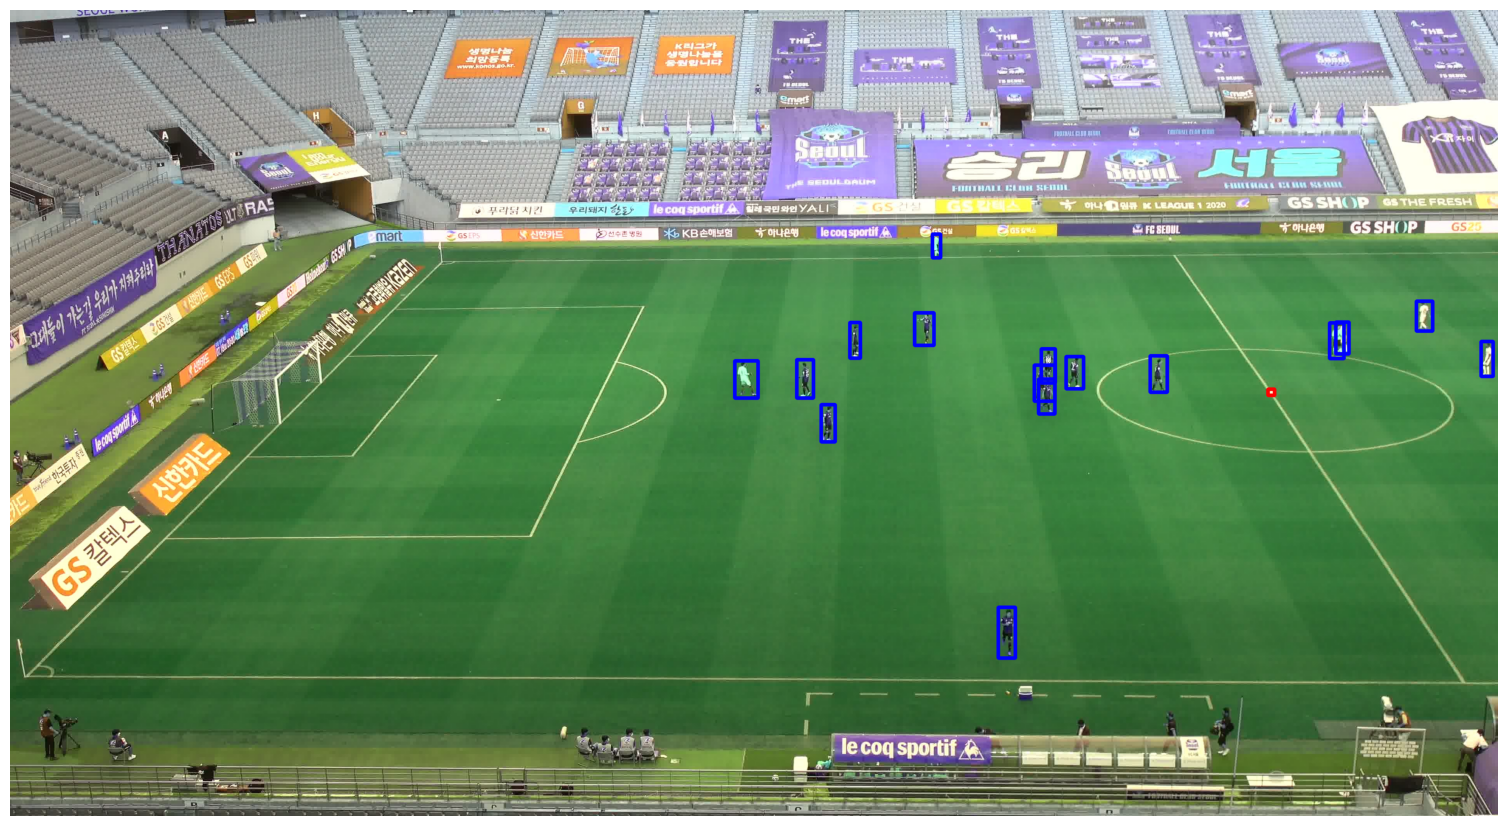

In [36]:
image_id = 0

image_file = image_df.at[image_id, "file_name"]
image = cv2.imread(f"datasets/soccer/{split_dir}/{image_file}")
image_labels = label_df[label_df["image_id"] == image_id]

colors = {1: [0, 0, 255], 37: [255, 0, 0]}
for i in image_labels.index:
    bbox = image_labels.at[i, "bbox"]
    color = colors[image_labels.at[i, "category_id"]]
    plot_one_box(bbox, image, color)

plt.figure(figsize=(19.2, 10.8))
plt.imshow(image)
plt.axis("off")
plt.grid(False)

##### (2) Visualizing an image with predicted bounding boxes

In [ ]:
model_name = "yolox_s"
exp_path = "exps/example/custom/yolox_s.py"
ckpt_path = "YOLOX_outputs/yolox_s/best_ckpt.pth"
image_path = "datasets/soccer/val2017/video_33_000203.jpg"
device = "cuda:0"

exp = get_exp(exp_path, model_name)
model = exp.get_model()
model.to(device)
model.eval()

ckpt = torch.load(ckpt_path, map_location="cpu")
model.load_state_dict(ckpt["model"])

<All keys matched successfully>

In [ ]:
predictor = Predictor(model, exp, COCO_CLASSES, device=device)
outputs, img_info = predictor.inference(image_path)
outputs[0].shape

2024-07-24 17:50:19.035 | INFO     | tools.demo:inference:201 - Infer time: 0.0435s


torch.Size([25, 7])

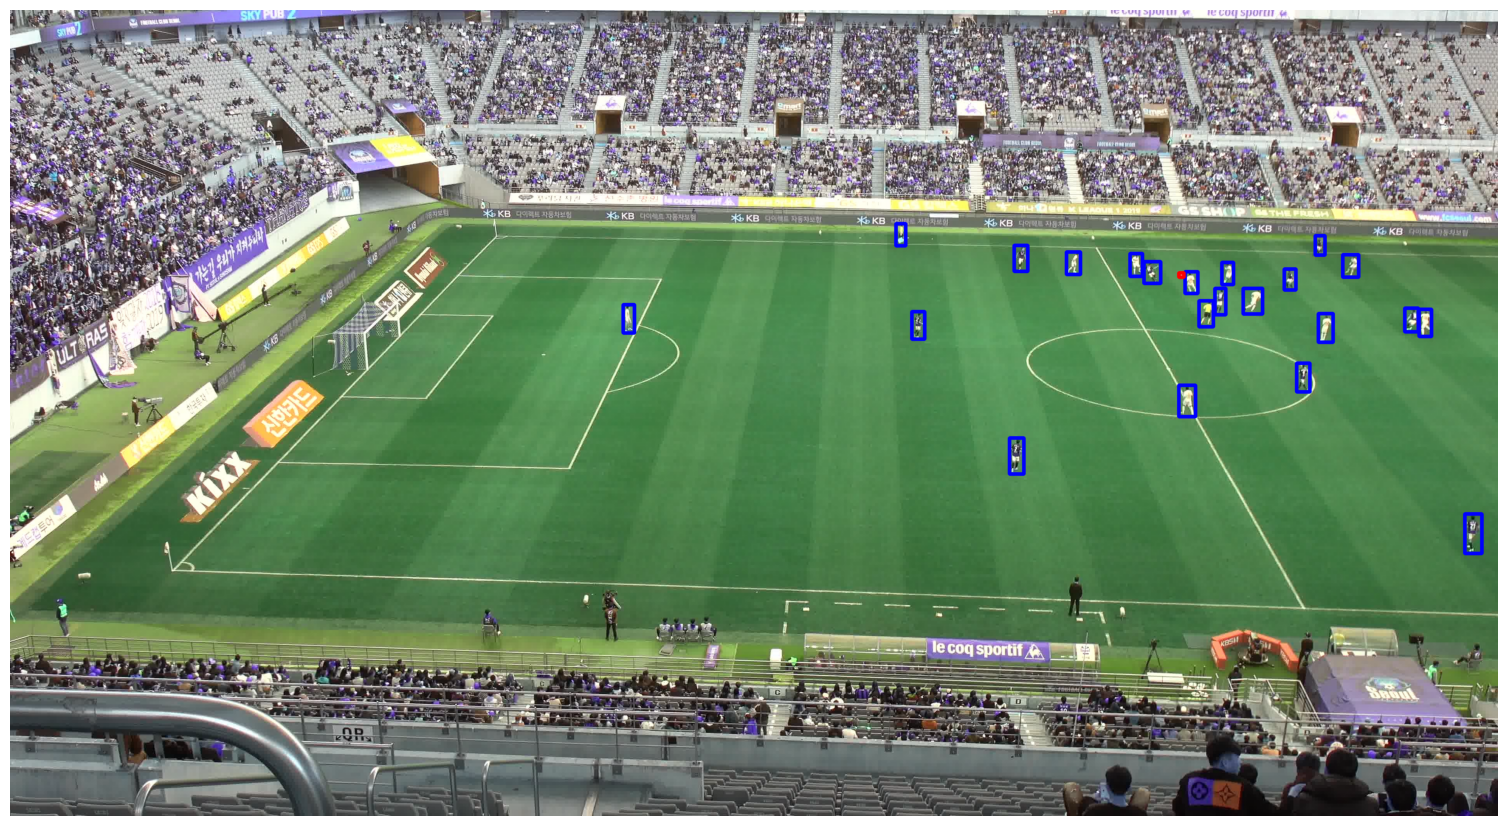

In [55]:
image = cv2.imread(image_path)
colors = {0: [0, 0, 255], 32: [255, 0, 0]}

for i in range(outputs[0].shape[0]):
    if outputs[0][i, 4] * outputs[0][i, 5] < 0.5:
        continue
    points = outputs[0][i, :4].cpu().numpy()
    bbox = points[0], points[1], points[2] - points[0], points[3] - points[1]
    color = colors[int(outputs[0][i, -1].item())]
    plot_one_box(bbox, image, color)

plt.figure(figsize=(19.2, 10.8))
plt.imshow(image)
plt.axis("off")
plt.grid(False)